### 合并单个股票文件中的指定列（amount）

单线程版本

In [ ]:
import pandas as pd
import os
from glob import glob

# 设置文件夹路径
folder_path = 'data/by_stock_merged'
# 指定要提取的列
column_to_extract = 'amount'
# 输出文件名
output_file = 'data/merged_data.parquet'

# 获取所有CSV文件的路径
csv_files = glob(os.path.join(folder_path, '*.csv'))

# 初始化一个空的DataFrame用于合并
merged_df = pd.DataFrame()

# 遍历所有CSV文件
for file in csv_files:
    # 提取股票代码
    stock_code = os.path.basename(file).split('.')[0]
    # 读取CSV文件
    df = pd.read_csv(file, usecols=['trade_time', column_to_extract])
    # 重命名列名为股票代码
    df = df.rename(columns={column_to_extract: stock_code})
    # 将trade_time设置为索引
    df['trade_time'] = pd.to_datetime(df['trade_time'])
    df = df.set_index('trade_time')
    # 合并数据
    if merged_df.empty:
        merged_df = df
    else:
        merged_df = pd.merge_ordered(merged_df, df, on='trade_time', how='outer')

# 重置索引
merged_df = merged_df.reset_index()

# 保存为Fastparquet文件
merged_df.to_parquet(output_file, engine='fastparquet', compression='ZSTD')

print(f"合并后的数据已保存为 {output_file}")


多线程版本

In [ ]:
import pandas as pd
import os
from glob import glob
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing
from tqdm import tqdm

# 设置文件夹路径
folder_path = 'data/by_stock_merged'
# 指定要提取的列
column_to_extract = 'amount'
# 中间文件存储路径
intermediate_folder_path = 'data/intermediate'


# 获取所有CSV文件的路径
csv_files = glob(os.path.join(folder_path, '*.csv'))

# 获取CPU核数
num_cores = multiprocessing.cpu_count() - 1

# 将文件分组
file_groups = [csv_files[i::num_cores] for i in range(num_cores)]

# 确保中间文件夹存在
if not os.path.exists(intermediate_folder_path):
    os.makedirs(intermediate_folder_path)

def process_group(files, group_index):
    print(f"开始处理组 {group_index}...\n")
    merged_df = pd.DataFrame()
    for idx, file in enumerate(files):
        # 提取股票代码
        stock_code = os.path.basename(file).split('.')[0]
        # 读取CSV文件
        df = pd.read_csv(file, usecols=['trade_time', column_to_extract])
        # 重命名列名为股票代码
        df = df.rename(columns={column_to_extract: stock_code})
        # 将trade_time设置为索引
        df['trade_time'] = pd.to_datetime(df['trade_time'])
        df = df.set_index('trade_time')
        # 合并数据
        if merged_df.empty:
            merged_df = df
        else:
            merged_df = pd.merge_ordered(merged_df, df, on='trade_time', how='outer')
        if group_index == 0:
            print(f"组 {group_index}: 已处理 {idx + 1}/{len(files)} 文件")
    # 保存中间文件
    intermediate_file = os.path.join(intermediate_folder_path, f'intermediate_{group_index}.parquet')
    merged_df.to_parquet(intermediate_file, engine='fastparquet', compression='ZSTD')
    # 清理内存
    del merged_df
    print(f"组 {group_index} 处理完成并保存为中间文件 {intermediate_file}")
    return intermediate_file

# 使用线程池并行处理文件组
# ~10min with 32 n2 CPU for this step
with ProcessPoolExecutor(max_workers=num_cores) as executor:
    future_to_group = {executor.submit(process_group, file_groups[i], i): i for i in range(num_cores)}
    intermediate_files = [future.result() for future in as_completed(future_to_group)]

# 清理文件组的内存
del file_groups
del csv_files


In [2]:
# 合并所有中间文件
# ~10mins with 32 n2 CPU for this step
final_df = pd.DataFrame()
output_file = f'data/merged_{column_to_extract}.parquet'

for intermediate_file in tqdm(intermediate_files, desc="合并中间文件"):
    df = pd.read_parquet(intermediate_file)
    if final_df.empty:
        final_df = df
    else:
        final_df = pd.merge_ordered(final_df, df, on='trade_time', how='outer')
    # 清理中间文件的内存
    del df

# 重置索引
final_df = final_df.reset_index()

# 保存最终合并的文件
final_df.to_parquet(output_file, engine='fastparquet', compression='ZSTD')

print(f"合并后的数据已保存为 {output_file}")

# 清理最终数据的内存
del final_df

# 删除中间文件
for intermediate_file in intermediate_files:
    os.remove(intermediate_file)

print("中间文件已删除，内存已清理")

合并中间文件: 100%|██████████| 31/31 [11:01<00:00, 21.33s/it]


合并后的数据已保存为 data/merged_data.parquet
中间文件已删除，内存已清理


### 获得停牌时间

In [1]:
import os
import pandas as pd
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm

# 定义处理单个文件的函数
def process_file(file_path):
    try:
        df = pd.read_csv(file_path)
        # 将trade_time列转换为日期格式，并提取日期
        df['date'] = pd.to_datetime(df['trade_time']).dt.date
        # 按日期汇总交易额
        daily_amount_sum = df.groupby('date')['amount'].sum()
        # 找到总交易额为0的日期
        suspend_days = daily_amount_sum[daily_amount_sum == 0].index.tolist()
        return os.path.basename(file_path).split('.')[0], suspend_days
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return os.path.basename(file_path).split('.')[0], []

files_dir = 'data/by_stock_merged/'
files = [os.path.join(files_dir, file) for file in os.listdir(files_dir)]

num_workers = max(1, os.cpu_count() - 1)
results = []

with ProcessPoolExecutor(max_workers=num_workers) as executor:
    futures = [executor.submit(process_file, file) for file in files]
    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing Files"):
        results.append(future.result())


results_df = pd.DataFrame(results, columns=['ticker', 'suspend_days'])
results_df.set_index('ticker', inplace=True)
output_path = 'data/all_suspend_days.pkl.zip'
results_df.to_pickle(output_path, compression='zip')

print(f"Results saved to {output_path}")


Processing Files: 100%|██████████| 5100/5100 [10:13<00:00,  8.31it/s]


Results saved to data/all_suspend_days.pkl.zip


In [3]:
import pandas as pd

# 读取之前保存的停牌日期数据
output_path = 'data/all_suspend_days.pkl.zip'
results_df = pd.read_pickle(output_path, compression='zip')

# 查询2010-01-04这天000603是否停牌
ticker = '000603'
date_to_check = pd.to_datetime('2010-01-04').date()

# 获取指定股票的停牌日期列表
suspend_days = results_df.loc[ticker, 'suspend_days']

# 判断指定日期是否在停牌日期列表中
is_suspended = date_to_check in suspend_days

print(f"股票 {ticker} 在 {date_to_check} {'停牌' if is_suspended else '未停牌'}")


股票 000603 在 2010-01-04 停牌


### 去掉停牌数据

读取必要数据

In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm

stock_data_df = pd.read_parquet('data/merged_amount.parquet')
stock_data_df.set_index('trade_time', inplace=True)
stock_data_df = stock_data_df.drop(columns=['index'])
print(stock_data_df.head())

suspend_df = pd.read_pickle('data/all_suspend_days.pkl.zip', compression='zip')
print(suspend_df.head(40))

                     688610  301381  000937  603727  300901  300838  603235  \
trade_time                                                                    
2000-01-04 09:31:00     NaN     NaN     0.0     NaN     NaN     NaN     NaN   
2000-01-04 09:32:00     NaN     NaN     0.0     NaN     NaN     NaN     NaN   
2000-01-04 09:33:00     NaN     NaN     0.0     NaN     NaN     NaN     NaN   
2000-01-04 09:34:00     NaN     NaN     0.0     NaN     NaN     NaN     NaN   
2000-01-04 09:35:00     NaN     NaN     0.0     NaN     NaN     NaN     NaN   

                     688631  601518  601375  ...  002738  002283   000906  \
trade_time                                   ...                            
2000-01-04 09:31:00     NaN     NaN     NaN  ...     NaN     NaN   7974.0   
2000-01-04 09:32:00     NaN     NaN     NaN  ...     NaN     NaN  19995.0   
2000-01-04 09:33:00     NaN     NaN     NaN  ...     NaN     NaN      0.0   
2000-01-04 09:34:00     NaN     NaN     NaN  ...     NaN     

去掉停牌数据（单线程）

In [5]:
stock_data_df.index = pd.to_datetime(stock_data_df.index)

# 遍历所有股票和对应的停牌日期
for ticker, suspend_dates in tqdm(suspend_df['suspend_days'].items(), total=suspend_df.shape[0], desc="Updating stock data"):
    ticker = str(ticker)  # 确保ticker格式为字符串，以匹配列名
    if suspend_dates:  # 如果有停牌日期
        for suspend_date in suspend_dates:  # 这里suspend_date是datetime.date类型
            # 创建当天的时间范围
            start_datetime = pd.Timestamp(suspend_date)
            end_datetime = start_datetime + pd.Timedelta(days=1)
            # 设置对应日期的收益率为NaN
            if ticker in stock_data_df.columns:
                # 查找这个日期范围内的所有时间点，并将它们设置为NaN
                stock_data_df.loc[(stock_data_df.index >= start_datetime) & (stock_data_df.index < end_datetime), ticker] = np.nan

# ~47mins on c2

Updating stock data: 100%|██████████| 5100/5100 [45:35<00:00,  1.86it/s]  


sanity check

In [6]:
ticker = '000603'

print(stock_data_df.loc['2010-01-04 09:31:00', ticker]) # should be NaN

nan


Text(0.5, 1.0, 'Stock 000603 Amount')

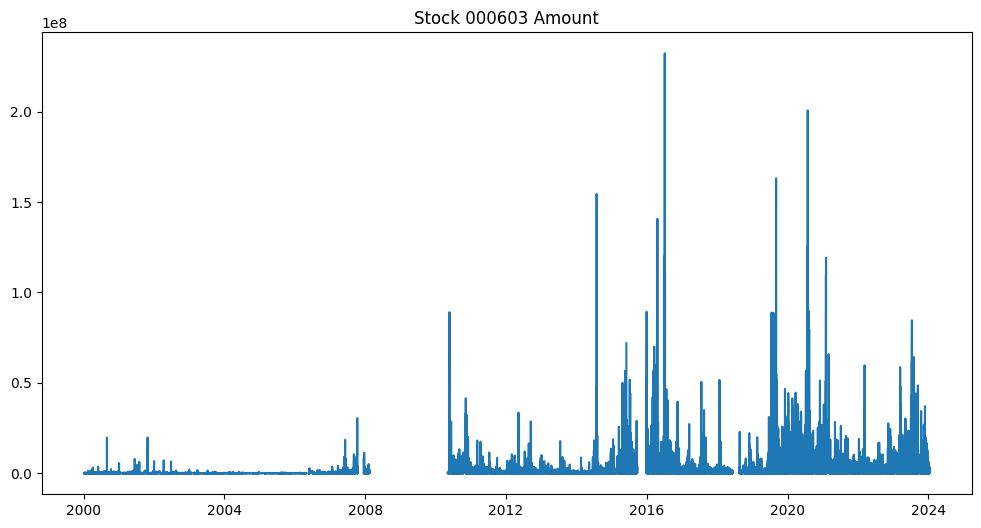

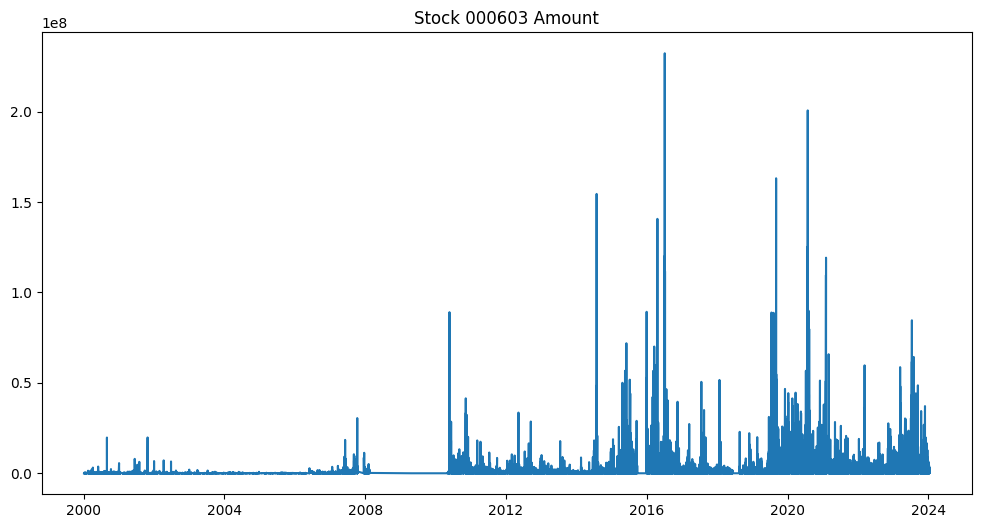

In [7]:
from matplotlib import pyplot as plt

# plot stock_data_df['000603']
plt.figure(figsize=(12, 6))
plt.plot(stock_data_df.index, stock_data_df[ticker])
plt.title(f'Stock {ticker} Amount')

stock_df = pd.read_csv(f'data/by_stock_merged/{ticker}.csv', usecols=['trade_time', 'amount'])
stock_df['trade_time'] = pd.to_datetime(stock_df['trade_time'])
stock_df = stock_df.set_index('trade_time')

# plot stock_df['amount']
plt.figure(figsize=(12, 6))
plt.plot(stock_df.index, stock_df['amount'])
plt.title(f'Stock {ticker} Amount')

In [8]:
output_path = 'data/stock_amounts_1m_all.parquet'
stock_data_df.to_parquet(output_path, engine='fastparquet', compression='ZSTD')